In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, omnipush_datasets

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [21]:
# Experiment configuration
experiment_name = "dpf_mujoco_32u"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [24]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel(units=32)
measurement_model = panda_models.PandaMeasurementModel(units=64)

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "dynamics_recurrent", "measurement"]
)
buddy.add_metadata(dataset_args)

buddy.load_checkpoint(experiment_name="dpf_mujoco_stable")

[buddy-dpf_mujoco_32u] Using device: cuda
[buddy-dpf_mujoco_32u] Loaded metadata: {'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_mujoco_32u] No checkpoint found
[buddy-dpf_mujoco_32u] Wrote metadata to: metadata/dpf_mujoco_32u.yaml
[buddy-dpf_mujoco_32u] Read checkpoint from path: checkpoints/dpf_mujoco_stable-0000000000183657.ckpt
[buddy-dpf_mujoco_32u] Loaded checkpoint at step: 183657


True

# Dataset Loading

In [5]:
# dynamics_trainset = omnipush_datasets.OmnipushDynamicsDataset(
#     "omnipush_data/ellip1_trainset.hdf5",
#     "omnipush_data/ellip2_trainset.hdf5",
#     "omnipush_data/ellip3_trainset.hdf5",
#     **dataset_args
# )
# dynamics_recurrent_trainset = omnipush_datasets.OmnipushSubsequenceDataset(
#     "omnipush_data/ellip1_trainset.hdf5",
#     "omnipush_data/ellip2_trainset.hdf5",
#     "omnipush_data/ellip3_trainset.hdf5",
#     subsequence_length=16,
#     **dataset_args
# )
# measurement_trainset = omnipush_datasets.OmnipushMeasurementDataset(
#     "omnipush_data/ellip1_trainset.hdf5",
#     "omnipush_data/ellip2_trainset.hdf5",
#     "omnipush_data/ellip3_trainset.hdf5",
#     samples_per_pair=10,
#     **dataset_args
# )
# e2e_trainset = omnipush_datasets.OmnipushParticleFilterDataset(
#     "omnipush_data/ellip1_trainset.hdf5",
#     "omnipush_data/ellip2_trainset.hdf5",
#     "omnipush_data/ellip3_trainset.hdf5",
#     subsequence_length=16,
#     particle_count=30,
#     particle_stddev=(.1, .1),
#     **dataset_args
# )
# eval_trajectories = omnipush_datasets.load_trajectories(
#     "omnipush_data/ellip1_testset.hdf5",
#     "omnipush_data/ellip2_testset.hdf5",
#     "omnipush_data/ellip3_testset.hdf5",
#     **dataset_args
# )
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_1000.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    **dataset_args
)
measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_1000.hdf5",
    samples_per_pair=10,
    **dataset_args
)
e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

Parsed data: 176075 active, 62925 inactive
Keeping: 62925



Loaded 240000 points
Parsed data: 13331 active, 1669 inactive
Keeping (inactive): 1669


# Dynamics Model Pre-Training

In [12]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(3):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1)
    print()

buddy.save_checkpoint("phase_0_dynamics_pretrain")

Training epoch 0



Epoch loss: 0.0023963996

Training epoch 1


[buddy-dpf_mujoco_64u] Saved checkpoint to path: checkpoints/dpf_mujoco_64u-0000000000010000.ckpt

Epoch loss: 0.002097157

Training epoch 2


[buddy-dpf_mujoco_64u] Saved checkpoint to path: checkpoints/dpf_mujoco_64u-0000000000020000.ckpt

Epoch loss: 0.001866815

[buddy-dpf_mujoco_64u] Saved checkpoint to path: checkpoints/dpf_mujoco_64u-phase_0_dynamics_pretrain.ckpt


In [18]:
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(3):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2')
    print()

buddy.save_checkpoint("phase_1_dynamics_pretrain_recurrent")

  0%|          | 0/469 [00:00<?, ?it/s]

eh!
Training epoch 0


  0%|          | 0/469 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Measurement Model Pre-Training

In [17]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16)

for i in range(2):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()



Training epoch 0


KeyboardInterrupt: 

In [ ]:
buddy.save_checkpoint("phase_2_measurement_pretrain")


# End-to-end Training

In [ ]:
print(len(e2e_trainset.subsequences))

In [30]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.01, 0.01)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = False

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", resample=False)

Training epoch 0



Epoch loss: 0.0020361256
Training epoch 1



Epoch loss: 0.0009013983
Training epoch 2


KeyboardInterrupt: 

In [ ]:
buddy.save_checkpoint("phase_3_end_to_end_trained")
buddy.save_checkpoint()

# Model eval

### Final Model

  0%|          | 1/239 [00:00<00:29,  8.08it/s]

[buddy-dpf_mujoco_32u] Saved checkpoint to path: checkpoints/dpf_mujoco_32u-0000000000186537.ckpt
phase_0_dynamics_pretrain


100%|██████████| 239/239 [00:20<00:00, 11.93it/s]


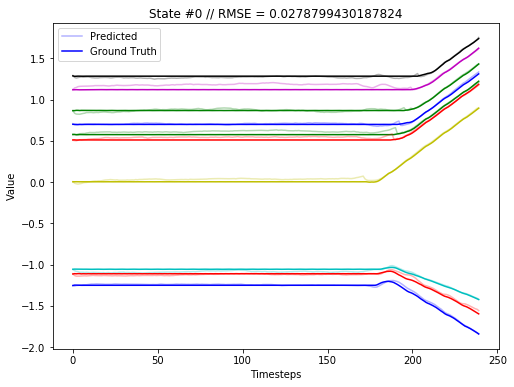

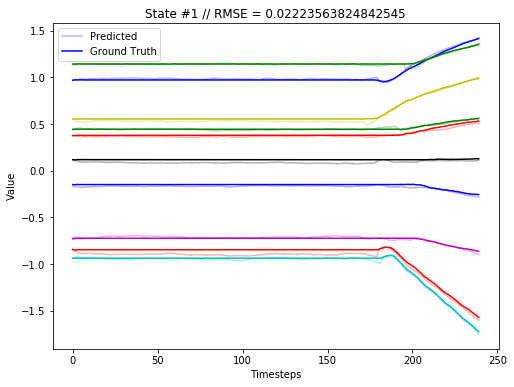

  1%|          | 2/239 [00:00<00:18, 12.51it/s]

(0.01, 0.01)
phase_1_dynamics_pretrain_recurrent


100%|██████████| 239/239 [00:20<00:00, 11.83it/s]


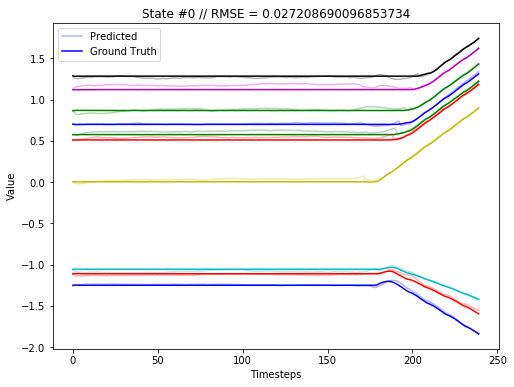

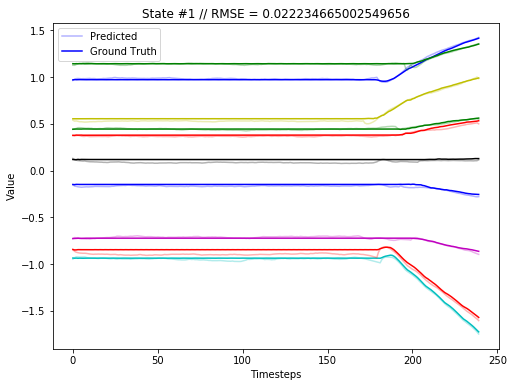

  1%|          | 2/239 [00:00<00:18, 12.95it/s]

(0.01, 0.01)
phase_2_measurement_pretrain


100%|██████████| 239/239 [00:19<00:00, 12.03it/s]


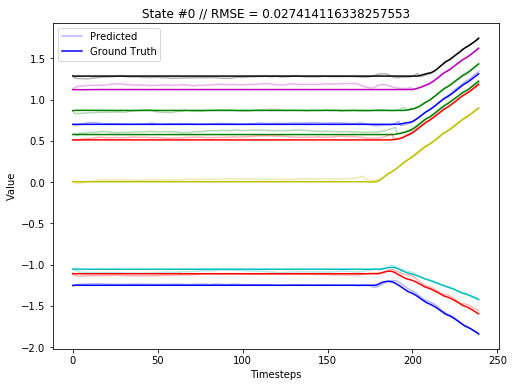

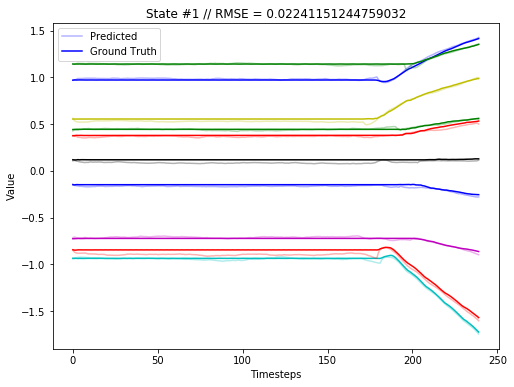

  1%|          | 2/239 [00:00<00:19, 11.94it/s]

(0.01, 0.01)
phase_3_end_to_end_trained


100%|██████████| 239/239 [00:19<00:00, 12.18it/s]


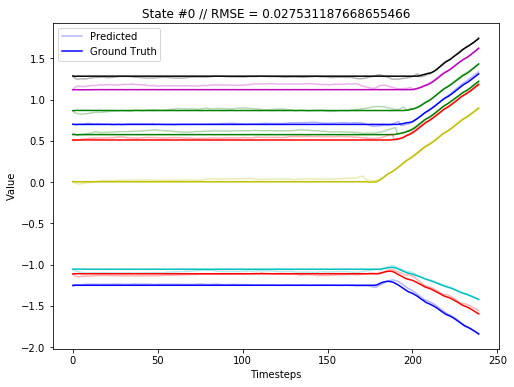

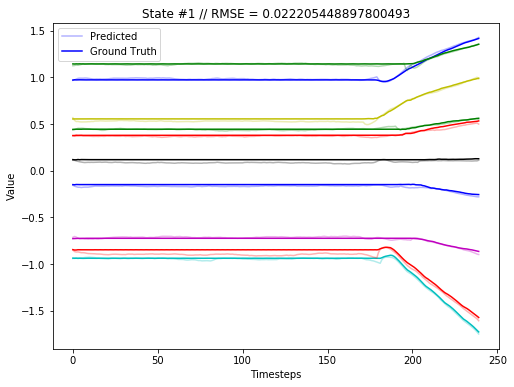

(0.01, 0.01)


In [31]:

# eval_trajectories = omnipush_datasets.load_trajectories(
#     ("omnipush_data/ellip1_trainset.hdf5",5),
#     **dataset_args
# )
phases = [
    'phase_0_dynamics_pretrain',
    'phase_1_dynamics_pretrain_recurrent',
    'phase_2_measurement_pretrain',
    'phase_3_end_to_end_trained'
]
buddy.save_checkpoint()
for phase in phases:
#     buddy.load_checkpoint(phase)
    print(phase)
    pf_model.dynamics_model.state_noise_stddev = (0.01, 0.01)
    pred, actual = panda_training.rollout(
        pf_model,
        eval_trajectories,
        start_time=0,
        max_timesteps=1000,
        particle_count=200,
        noisy_dynamics=True,
        true_initial=True)
    panda_training.eval_rollout(pred, actual, plot=True)
    print(pf_model.dynamics_model.state_noise_stddev)

[buddy-dpf_mujoco_32u] Saved checkpoint to path: checkpoints/dpf_mujoco_32u-0000000000183657.ckpt
phase_0_dynamics_pretrain


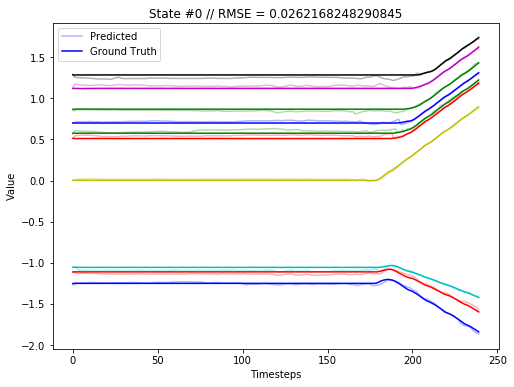

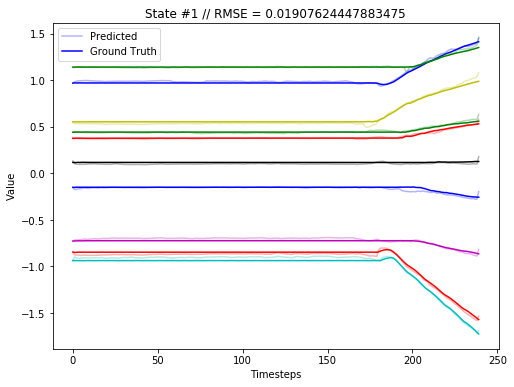

(0.01, 0.01)
phase_1_dynamics_pretrain_recurrent


KeyboardInterrupt: 

In [25]:

# eval_trajectories = omnipush_datasets.load_trajectories(
#     ("omnipush_data/ellip1_trainset.hdf5",5),
#     **dataset_args
# )
phases = [
    'phase_0_dynamics_pretrain',
    'phase_1_dynamics_pretrain_recurrent',
    'phase_2_measurement_pretrain',
    'phase_3_end_to_end_trained'
]
buddy.save_checkpoint()
for phase in phases:
#     buddy.load_checkpoint(phase)
    print(phase)
    pf_model.dynamics_model.state_noise_stddev = (0.01, 0.01)
    pred, actual = panda_training.rollout(
        pf_model,
        eval_trajectories,
        start_time=0,
        max_timesteps=1000,
        particle_count=200,
        noisy_dynamics=True,
        true_initial=True)
    panda_training.eval_rollout(pred, actual, plot=True)
    print(pf_model.dynamics_model.state_noise_stddev)

In [ ]:

eval_trajectories = omnipush_datasets.load_trajectories(
    ("omnipush_data/ellip1_trainset.hdf5", 20),
    **dataset_args
)

### Model without end-to-end training

In [ ]:
# pf_model.dynamics_model.state_noise = (0.005, 0.005)


# # Back up model
# buddy.save_checkpoint()

# # Load the pre-end-to-end-training version of the model & evaluate
# buddy.load_checkpoint(label="before_e2e_training")

# pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
# panda_training.eval_rollout(pred, actual, plot=True)

# # Restore model
# buddy.load_checkpoint()

In [39]:
buddy.save_checkpoint()

[buddy-dpf_omnipush2] Skipping redundant checkpoint save
